In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime as datetime
import matplotlib.colors as mcolors

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [4]:
ds = xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2010_2015_10min.nc')
#ds = xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2009_2021_5min.nc')
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (dt: 315504, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 3MB 2010-01-01 ... 2015-12-31T23:50:00
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables:
    jPar            (dt, mlat, mlt) float64 3GB ...
    BX_GSE          (dt) float64 3MB ...
    BY_GSE          (dt) float64 3MB ...
    BZ_GSE          (dt) float64 3MB ...
    flow_speed      (dt) float64 3MB ...
    proton_density  (dt) float64 3MB ...

In [5]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, nan_count, np.round(nan_ratio, 2)

nan_count(ds, 'jPar')

(378604800, 0, 0.0)

(array([1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 6.0000000e+00, 3.0000000e+00, 3.0000000e+00,
        1.0000000e+00, 5.0000000e+00, 5.0000000e+00, 8.0000000e+00,
        8.0000000e+00, 9.0000000e+00, 1.4000000e+01, 1.7000000e+01,
        1.8000000e+01, 2.2000000e+01, 2.1000000e+01, 3.5000000e+01,
        3.8000000e+01, 3.9000000e+01, 5.7000000e+01, 9.4000000e+01,
        1.3600000e+02, 1.8500000e+02, 3.0500000e+02, 4.5500000e+02,
        7.0600000e+02, 9.6700000e+02, 1.6710000e+03, 2.7970000e+03,
        4.6950000e+03, 7.8840000e+03, 1.3266000e+04, 2.3465000e+04,
        4.1355000e+04, 7.2015000e+04, 1.2965700e+05, 2.3302600e+05,
        4.2618400e+05, 7.9975600e+05, 1.5720920e+06, 3.4094460e+06,
        8.8533210e+06, 3.2927873e+07, 2.0285135e+08, 9.9606417e+07,
        1.6654968e+07, 5.7423480e+06, 2.5263260e+06, 1.2495160e+06,
        6.5641900e+05, 3.5276900e+05, 1.9411000e

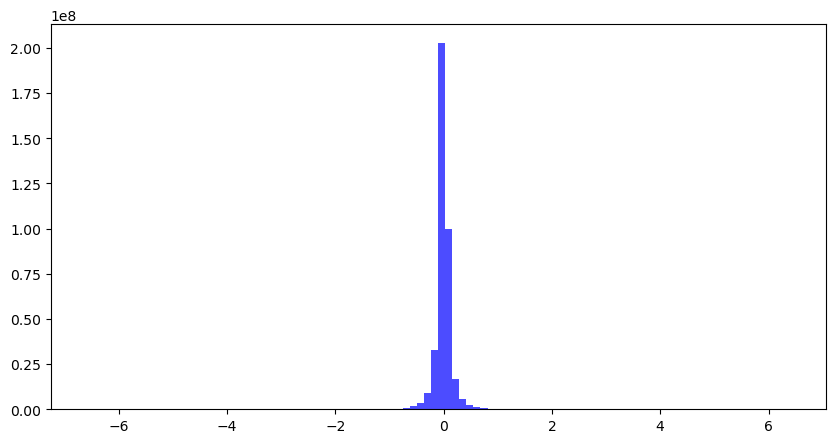

In [13]:
#plot jpar as hist
plt.figure(figsize=(10, 5))
plt.hist(ds['jPar'].values.flatten(), bins=100, color='b', alpha=0.7)

In [14]:
np.std(ds['jPar'].values.flatten())


0.15106579111752813

In [6]:
input_scaler = StandardScaler()

# Extract the target variable and reshape for scaling
target_var = ds['jPar'].values  # shape (t (n), mlat (50), mlt (24))

# Extract and scale input variables (variables that are dependent only on 'dt')
input_vars = ['BX_GSE', 'BY_GSE', 'BZ_GSE', 'flow_speed', 'proton_density']
input_data = np.array([ds[var].values for var in input_vars]).T  # shape (22320, number_of_vars)
input_data_scaled = input_scaler.fit_transform(input_data)

file_path = f'scaler_id3.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(input_scaler, file)

def create_sequences(target_data, input_data, lookback=30):
    X, y = [], []
    for i in range(len(target_data) - lookback):
        X.append(input_data[i:i+lookback].T)
        y.append(target_data[i+lookback])

    return np.array(X), np.array(y)

lookback = 6
X, y = create_sequences(target_var, input_data_scaled, lookback=lookback)
X.shape, y.shape

((315498, 5, 6), (315498, 50, 24))

In [7]:
def simple_time_series_split(X, y, train_ratio=0.9, test_ratio=0.09):

    # Calculate split indices
    train_idx = int(len(X) * train_ratio)
    test_idx = int(len(X) * (train_ratio + test_ratio))

    # Perform the split
    X_train, X_val, X_test = X[:train_idx], X[train_idx:test_idx], X[test_idx:]
    y_train, y_val, y_test = y[:train_idx], y[train_idx:test_idx], y[test_idx:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = simple_time_series_split(X, y)
X_train.shape, X_val.shape, X_test.shape

((283948, 5, 6), (28395, 5, 6), (3155, 5, 6))

In [8]:
# Convert data to PyTorch tensors and move to GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
#X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
#y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset,  shuffle=False, batch_size=batch_size)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += identity
        out = F.relu(out)

        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(64)
        
        self.resblock1 = ResidualBlock(64, 64)
        self.resblock2 = ResidualBlock(64, 64)
        self.resblock3 = ResidualBlock(64, 64)
        
        self.fc1 = nn.Linear(5 * 6 * 64, 1200)
        self.fc2 = nn.Linear(1200, 50 * 24)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Adding a channel dimension (assuming grayscale image input)
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 50, 24)  # Reshape to 50x24 map
        
        return x

# Example usage
model = CNN()
model.to(device)


CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn

In [10]:
loss_function = nn.L1Loss() #AKA MAE
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=25, gamma=0.7)

In [11]:
#Train the model
num_epochs = 7
train_losses = []
val_losses = []

# Early stopping
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Forward pass
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        train_outputs = model(X_batch)
        loss = loss_function(train_outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss += loss_function(val_outputs, y_batch).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_kunduri_model.pt')
    else:
        counter += 1
        if counter == patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
            break
        else:
            continue

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss (MAE): {train_loss:.4f}, Val Loss (MAE): {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.1e}')

   

Epoch [1/7], Train Loss (MAE): 0.0914, Val Loss (MAE): 0.1033, Best Val Loss: 0.1033, LR: 1.0e-05
Epoch [2/7], Train Loss (MAE): 0.0840, Val Loss (MAE): 0.1020, Best Val Loss: 0.1020, LR: 1.0e-05
Epoch [3/7], Train Loss (MAE): 0.0834, Val Loss (MAE): 0.1017, Best Val Loss: 0.1017, LR: 1.0e-05
Epoch [4/7], Train Loss (MAE): 0.0832, Val Loss (MAE): 0.1016, Best Val Loss: 0.1016, LR: 1.0e-05
Epoch [5/7], Train Loss (MAE): 0.0831, Val Loss (MAE): 0.1014, Best Val Loss: 0.1014, LR: 1.0e-05
Epoch [6/7], Train Loss (MAE): 0.0829, Val Loss (MAE): 0.1013, Best Val Loss: 0.1013, LR: 1.0e-05
Epoch [7/7], Train Loss (MAE): 0.0828, Val Loss (MAE): 0.1011, Best Val Loss: 0.1011, LR: 1.0e-05
